__Dependencies__

In [1]:
import copy  # copy big/deep objects by value
import datetime  # datetime operations
import itertools  # operate with iterators
import json  # read/write from/into json format
import os  # OS operations (read/write files/folders)
import warnings  # hide warnings

# process parallelization
from multiprocessing import Manager, Pool, RawArray, cpu_count

import matplotlib.pyplot as plt  # mother of plots focr Python
import matplotlib.ticker as ticker  # matplotlib ticker utils
import numpy as np  # array/matrix operations (e.g. linear algebra)
import pandas as pd  # operate with dataframes
import seaborn as sns  # matplotlib plotting nice with shortcuts
from IPython.display import display  # print nicely
from tqdm.notebook import tqdm  # mother of progressbars for Python

# from matplotlib.ticker import FormatStrFormatter  # tick formatter

__Options__

In [2]:
warnings.filterwarnings("ignore")
# set default float display format to 2 decimals
pd.options.display.float_format = "{:.2f}".format

STYLE = "darkgrid"
sns.set_style(STYLE)  # set seaborn plotting style

PATH_COLLS = "./data/colliders"
PATH_GAZES = "./data/gazes"
PATH_HITS = "./data/hits"

CORES = cpu_count()  # number of cpu threads for multiprocessing
print(f"Total CPU threads: {CORES}")

Total CPU threads: 12


__Helper functions__

In [3]:
def angle(a, b):
    """
    Angle (in degrees) between two vectors.

    Given two 3D vectors (a and b):
    a = [xa, ya, za] , b = [xb, yb, zb]

    And the basic geometric formula for the dot product:
    a · b = |a| * |b| * cos(α) => α = arccos[(a · b) / (|a| * |b|)]

    In other words:
    angle = arccos[(xa * xb + ya * yb + za * zb) / (√(xa2 + ya2 + za2) * √(xb2 + yb2 + zb2))]

    Source: https://www.omnicalculator.com/math/angle-between-two-vectors

    Parameters:
        a (numpy.array): First vector
        b (numpy.array): Second vector
    Returns:
        float: Angle between vectors a and b in degrees.
    """
    # a · b
    dotp = np.dot(a, b)

    # magnitude vectors |a| and |b|
    m_a = np.linalg.norm(a)
    m_b = np.linalg.norm(b)

    # |a| * |b|
    m_prod = m_a * m_b

    # (a * b) / (|a| * |b|)
    res = dotp / m_prod

    # α = arccos[(a · b) / (|a| * |b|)]
    an = np.arccos(res)

    # calculated angle from radians to degrees
    return np.degrees(an)

__Read participants cleaned data__

In [4]:
parts = pd.read_csv("./data/participants.csv", keep_default_na=False)
parts = parts.set_index("uid")  # set uid column as index (remove default)
parts

,date,Intention,Usefulness,Ease,Trust,Gender,Age,Aviophobia,Driving,Play,VR,expo,file,created,condition,frames
uid,,,,,,,,,,,,,,,,
ec61bab6e46741969bceb80ee2246983,2019-05-26 12:06:22,50,50,50,50,intersex,25,1,80,58,more than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-ec61bab6e46741...,10.03.2020 01:11,RadioTalk,3070
1fbde03890d94bddaf7aa987fc732607,2019-05-26 16:02:45,100,100,100,96,Male,13,0,0,5,once,MSW,Path_ MS Wissenschaft-RadioTalk-1fbde03890d94b...,18.02.2020 16:24,RadioTalk,3070
1ad9eea672a94518b150925bac41fcbc,2019-05-26 17:23:38,17,22,0,86,Female,24,0,4,2,once,MSW,Path_ MS Wissenschaft-RadioTalk-1ad9eea672a945...,09.03.2020 21:31,RadioTalk,3070
461b2d80132f47958e50003c16084cf4,2019-05-26 17:27:34,30,70,80,80,Male,22,0,3,1,less than 10 times,MSW,Path_ MS Wissenschaft-TaxiDriver-461b2d80132f4...,10.03.2020 02:40,TaxiDriver,3070
4f300efb4a9941f7a96f57e8030b12e2,2019-05-26 17:39:25,100,100,50,50,Male,16,0,0,3,less than 10 times,MSW,Path_ MS Wissenschaft-RadioTalk-4f300efb4a9941...,09.03.2020 22:19,RadioTalk,3070
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eda9175e9e1d4153ac2ca3038b2ab008,2019-12-23 09:23:08,65,30,33,20,Male,12,0,0,25,once,BMBF,Path_ MS Wissenschaft-RadioTalk-eda9175e9e1d41...,24.01.2020 13:28,RadioTalk,3070
b8c9e625f07444cc8d4a0fc245bab5dd,2019-12-23 09:28:25,100,50,50,100,Female,12,1,99,9,less than 10 times,BMBF,Path_ MS Wissenschaft-TaxiDriver-b8c9e625f0744...,24.01.2020 15:06,TaxiDriver,3070
2cd78ad9a37945de9f8cfd5f81c42082,2019-12-27 12:56:23,86,20,71,69,Male,57,0,39,0,never,BMBF,Path_ MS Wissenschaft-RadioTalk-2cd78ad9a37945...,24.01.2020 11:49,RadioTalk,3070


Participant data example to process

In [5]:
df_part = pd.read_csv(
    f"{PATH_COLLS}/{parts.iloc[0].file}", keep_default_na=False
)
df_part = df_part.set_index("frameNumber")
df_part

,trackerPosition,trackerRotation,centerHit,centerHitPosition,centerHitGroup,boxHit,boxHitPosition,boxHitGroup,presentObjectName,presentObjectGroup
frameNumber,,,,,,,,,,
400,"(-193.8, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 108.8, -150.2)",WestRide Buildings,TS1 Stand Medium,"(-141.6, 98.5, -135.4)",WestRide Traffic,Building01*Building 4*Building 3*TS1_Stand_Med...,WestRide Buildings*WestRide Buildings*WestRide...
401,"(-193.8, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 110.2, -149.6)",WestRide Buildings,TS1 Stand Medium,"(-141.6, 98.8, -135.4)",WestRide Traffic,Building01*Building 4*Building 3*TS1_Stand_Med...,WestRide Buildings*WestRide Buildings*WestRide...
402,"(-193.7, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 111.8, -147.6)",WestRide Buildings,TS1 Stand Medium,"(-141.6, 99.2, -135.4)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
403,"(-193.7, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(59.2, 114.3, -143.0)",WestRide Buildings,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
404,"(-193.7, 102.3, -131.7)","(0.1, 0.7, 0.1, 0.7)",Building 3,"(62.3, 115.7, -137.6)",WestRide Buildings,Circle_Sign_LOD0,"(-141.2, 101.2, -135.1)",WestRide Traffic,Building 3*TS1_Stand_Medium_LOD0*Square_Sign_L...,WestRide Buildings*WestRide Traffic*WestRide T...
...,...,...,...,...,...,...,...,...,...,...
3066,"(-41.4, 102.3, -199.4)","(0.1, 0.8, 0.0, -0.6)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 103.6, -205.3)",WestRide Buildings,3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 100.1, -200.1)",WestRide Buildings,Building 4*Building 3*Circle_Sign_LOD0*TS1_Sta...,WestRide Buildings*WestRide Buildings*WestRide...
3067,"(-41.7, 102.3, -199.4)","(0.1, 0.8, 0.0, -0.6)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 103.7, -204.8)",WestRide Buildings,3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 100.1, -200.1)",WestRide Buildings,Building 4*Building 3*TS1_Stand_Medium_LOD0*TS...,WestRide Buildings*WestRide Buildings*WestRide...
3068,"(-41.9, 102.3, -199.4)","(0.1, 0.8, 0.0, -0.6)",3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 103.8, -204.5)",WestRide Buildings,3841_combined_LB_building-2 [Legacy Shaders/R...,"(-72.0, 100.1, -200.1)",WestRide Buildings,Building 4*Building 3*Square_Sign_LOD0*TS1_Sta...,WestRide Buildings*WestRide Buildings*WestRide...


Process all participants counting and groupping consecutive hitpoints

In [6]:
def check_consecutive(uid_htype):
    """
    Process a participant hit-related information given an id.

    Compute the total of consecutive hits, nulls and store it into a shared-memory array.
    Compute and store nose vectors, distances, and angles into a CSV.
    Compute and store saccade/fixation/gaze events information.

    Parameters:
        uid_htype (tuple): Participant identifier and hit type(box or center).
    """

    uid = uid_htype[0]
    htype = uid_htype[1]

    # participant colliders filename
    file = parts.loc[uid].file
    # index of the participant to match the array row on the hits calculations
    idx = parts.index.get_loc(uid)
    p = pd.read_csv(f"{PATH_COLLS}/{file}", keep_default_na=False)

    # boolean expressing if hit type is center or not (box)
    chit = htype == "center"
    # use previous logic to select the right column
    hlabel = "centerHit" if chit else "boxHit"

    # participant hits dict to fill out and generate a df in the end
    cons = {
        "frameNumber": [],
        # trackerPosition
        "trackerX": [],
        "trackerY": [],
        "trackerZ": [],
        # nose vector between trackerPosition and center/boxHit
        "noseVectorX": [],
        "noseVectorY": [],
        "noseVectorZ": [],
        # angle between consecutive nose vectors
        "angle": [],
        # euclidean distance between HitPosition and trackerPosition
        "noseDistance": [],
        # euclidean distance between consecutive hitPositions
        "objectDistance": [],
    }

    # dicts to store gaze-event related information
    gazes = {
        "firstFrame": [],
        "lastFrame": [],
        "hits": [],
        "object": [],
        "group": [],
    }

    # create dicts to keep up with center and box hits counters:
    # hit (center/boxHit), previous (p), current (c), next(n)
    hit = {"p": None, "c": None, "n": None, "cnt": 0}

    # initialize box and center nose vector and hitPosition temporary lists
    vector = []
    hitpos = []
    frames = []
    N = p.index.size
    for i in range(N):  # iterate over all samples (frames)
        # parse trackerPosition (x, y, z)
        x, y, z = (
            p.iloc[i].trackerPosition.split("(")[1].split(")")[0].split(",")
        )
        hit["p"] = hit["c"]
        hit["c"] = p.iloc[i][hlabel]
        # because the comparison is between previous, current and next frame
        # and for the first frame the previous is anyways null (default init)
        if i + 1 < N:
            hit["n"] = p.iloc[i + 1].centerHit
        if hit["c"] != "null":  # current centerHit sample is not "null"
            # store it
            cons["trackerX"].append(x)
            cons["trackerY"].append(y)
            cons["trackerZ"].append(z)
            # hitPosition coordinates
            x1, y1, z1 = (
                p.iloc[i]
                .centerHitPosition.split("(")[1]
                .split(")")[0]
                .split(",")
            )
            # origin -> nose vector starting point, end -> NV ending point
            origin = np.array([float(x), float(y), float(z)])
            end = np.array([float(x1), float(y1), float(z1)])
            # store hit positions on objects to compute distances between them
            hitpos.append(end)
            # compute and store the nose vector for consecutive hits
            nose = end - origin  # same as np.subtract(end, origin)
            vector.append(nose)
            curr_frame = p.iloc[i].frameNumber
            cons["frameNumber"].append(curr_frame)
            frames.append(curr_frame)
            # euclidean distance between origin and end points (nose vector)
            dist = np.linalg.norm(nose)
            cons["centerDistance"].append(dist)  # store it
            # initialize to 1 if previous and current object names differ
            # otherwise increment
            hit["cnt"] = 1 if hit["p"] != hit["c"] else hit["cnt"] + 1
            # when no more consecutives (current and next are different)
            if hit["c"] != hit["n"] or i == N - 1:
                # increment consecutive hits for the given participant
                if chit:
                    chits[idx, hit["cnt"]] += 1
                else:
                    bhits[idx, hit["cnt"]] += 1
                if len(vector) > 1:  # more than 1 (consecutive) hit
                    for v, _ in enumerate(vector):
                        # store coordinates of consecutive nose vectors
                        cons["noseVectorX"].append(vector[v][0])
                        cons["noseVectorY"].append(vector[v][1])
                        cons["noseVectorZ"].append(vector[v][2])
                        # add initial angle as 0 as always current - previous
                        if v == 0:
                            cons["angle"].append(0.0)
                            cons["objectDistance"].append(0.0)
                        if v < len(vector) - 1:
                            # select current and next vector
                            v0 = vector[v]
                            v1 = vector[v + 1]
                            # (v0 == v1).all() same as np.array_equal(v0, v1)
                            # calculate angle only if the vectors differ
                            an = 0.0 if (v0 == v1).all() else angle(v0, v1)
                            cons["angle"].append(an)
                            h0 = hitpos[v]
                            h1 = hitpos[v + 1]
                            # calculate hit distance only if coordinates differ
                            hdiff = not (h0 == h1).all()
                            # same as h1 - h0
                            di = np.linalg.norm(h0 - h1) if hdiff else 0.0
                            cons["objectDistance"].append(di)
                else:  # for 1 hit
                    # store the nose vector and the rest as zeros (avoid NaNs)
                    cons["noseVectorX"].append(vector[0][0])
                    cons["noseVectorY"].append(vector[0][1])
                    cons["noseVectorZ"].append(vector[0][2])
                    cons["angle"].append(0.0)
                    cons["objectDistance"].append(0.0)
                gazes["firstFrame"].append(frames[0])
                gazes["lastFrame"].append(frames[-1])
                gazes["hits"].append(len(frames))
                gazes["object"].append(p.iloc[i][hlabel])
                gazes["group"].append(p.iloc[i][f"{hlabel}Group"])
                # reset consecutive counter and temporary nose vector lists
                hit["cnt"] = 0
                vector = []
                hitpos = []
                frames = []
        else:
            # increment the number of consecutive hits for the participant
            if chit:
                chits[idx, 0] += 1
            else:
                bhits[idx, 0] += 1
            # reset consecutive counter and current object name
            hit["cnt"] = 0
            hit["c"] = None
            # reset consecutive counter and temporary nose vector lists
            vector = []
            hitpos = []
            frames = []

    # hits and gaze dicts to df
    df_cons = pd.DataFrame(cons)
    df_gazes = pd.DataFrame(gazes)
    # store participant processed data as csv
    df_cons.to_csv(f"{PATH_HITS}/{htype}/{file}", index=False)
    df_gazes.to_csv(f"{PATH_GAZES}/{htype}/{file}", index=False)


# define our iterable using a generator containing tuples (uid, hitType)
htyp = ["center", "box"]
uids = parts.index.to_list()
uids_len = len(uids)
uids_gen = ((u, htyp[i % 2]) for u in uids for i, _ in enumerate(range(2)))
gen_len = 2 * uids_len

# since the experiment lasts 90 seconds
# the maximum, although not really possible, n_samples
# looking at the same object/spot would be 90s * 30FPS = 2700
# but the index size of each participant it's actually 2671
MAX = df_part.index.size

# duplicate array (for box and center hits)
# shared memory Array(ctype_or_ctype_code, size or initializer)
# only 1D arrays allowed, it will create an array of uids_len x N of zeros
chits = RawArray("i", uids_len * MAX)
bhits = RawArray("i", uids_len * MAX)
# each row will represent the consecutive hits computed per participant
# thus wrap it as a np array for [row, col] slicing and indexing convenience
chits = np.frombuffer(chits, dtype=np.int32).reshape((uids_len, MAX))
bhits = np.frombuffer(bhits, dtype=np.int32).reshape((uids_len, MAX))

pool = Pool(processes=CORES)

# progress bar format definitons
m_format = """📄 {n_fmt} of {total_fmt} {desc} processed: {bar}
            {percentage:3.0f}% ⏱️{elapsed} ⏳{remaining} 📅{eta:%d/%m/%y}
             🕒{eta:%H:%M}"""

# participants progress bar
parts_progress = tqdm(
    iterable=pool.imap_unordered(func=check_consecutive, iterable=uids_gen),
    total=gen_len,
    desc="📂 participants",
    dynamic_ncols=True,
    mininterval=0.001,
    bar_format=m_format,
)

# loop necessary for displaying properly the progressbar with multiprocessing
# source: https://stackoverflow.com/a/40133278
for _ in parts_progress:
    pass

# close pool instance, no more work to submit
pool.close()
# wait for the worker processes to terminate
pool.join()
# parts_progress.close()  # only needed when the pbar is updated manually

📄 0 of 7913 📂 participants processed:           
              0% ⏱️00:00 ⏳? 📅01/01/70
             🕒00:00

Parse the consecutive hits calculations (arrays `chits` and `bhits`) as a dataframe

In [9]:
cols = [i for i in range(MAX)]  # generate cols (0-N)
# add two extra columns at the beginning of the list
cols.insert(0, "uid")  # first col

# empty df with given cols
df_center = pd.DataFrame(columns=cols)
df_box = pd.DataFrame(columns=cols)

# progress bar from participants uid list
progress = tqdm(iterable=parts.index.to_list())

# dict to store center and box consecutive hit counters
hits_c = {i: [] for i in range(MAX)}
hits_b = {i: [] for i in range(MAX)}
# include keys to store participant uid and hit type (center/box)
hits_c["uid"] = []
hits_b["uid"] = []

# iterate over each participant while updating the pbar
for idx, part in enumerate(progress):
    # store participant hit counters (center and box)
    for i in range(MAX):
        hits_c[i].append(chits[idx, i])
        hits_b[i].append(bhits[idx, i])
    # store participant uid and hit type
    hits_c["uid"].append(part)
    hits_b["uid"].append(part)

# add all participants hit counters to the empty dataframe
df_center = df_center.append(pd.DataFrame(hits_c), ignore_index=True)
df_box = df_box.append(pd.DataFrame(hits_b), ignore_index=True)

df_center.to_csv("./data/center_hits.csv", index=False)
df_box.to_csv("./data/box_hits.csv", index=False)

df_center

  0%|          | 0/7913 [00:00<?, ?it/s]

,uid,0,1,2,3,4,5,6,7,8,...,2661,2662,2663,2664,2665,2666,2667,2668,2669,2670
0,ec61bab6e46741969bceb80ee2246983,833,45,15,8,9,12,2,4,2,...,0,0,0,0,0,0,0,0,0,0
1,1fbde03890d94bddaf7aa987fc732607,2527,15,7,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1ad9eea672a94518b150925bac41fcbc,601,62,31,13,12,9,2,9,1,...,0,0,0,0,0,0,0,0,0,0
3,461b2d80132f47958e50003c16084cf4,1929,23,9,2,6,4,6,4,1,...,0,0,0,0,0,0,0,0,0,0
4,4f300efb4a9941f7a96f57e8030b12e2,2649,7,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,90,25,18,17,6,10,4,4,...,0,0,0,0,0,0,0,0,0,0
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,53,21,9,9,4,8,5,6,...,0,0,0,0,0,0,0,0,0,0
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,43,10,2,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,1,3,2,2,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [34]:
df_chits = pd.read_csv("./data/chits.csv")
df_bhits = pd.read_csv("./data/bhits.csv")

Get rid of columns with only zeros (no consecutive hits) from right (biggest) to left (smallest) until first non-zero encountered

In [35]:
df_chits

,uid,0,1,2,3,4,5,6,7,8,...,662,663,664,665,666,667,668,669,670,671
0,ec61bab6e46741969bceb80ee2246983,833,45,15,8,9,12,2,4,2,...,0,0,0,0,0,0,0,0,0,0
1,1fbde03890d94bddaf7aa987fc732607,2527,15,7,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1ad9eea672a94518b150925bac41fcbc,601,62,31,13,12,9,2,9,1,...,0,0,0,0,0,0,0,0,0,0
3,461b2d80132f47958e50003c16084cf4,1929,23,9,2,6,4,6,4,1,...,0,0,0,0,0,0,0,0,0,0
4,4f300efb4a9941f7a96f57e8030b12e2,2649,7,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,90,25,18,17,6,10,4,4,...,0,0,0,0,0,0,0,0,0,0
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,53,21,9,9,4,8,5,6,...,0,0,0,0,0,0,0,0,0,0
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,43,10,2,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,1,3,2,2,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [36]:
df_bhits

,uid,0,1,2,3,4,5,6,7,8,...,662,663,664,665,666,667,668,669,670,671
0,ec61bab6e46741969bceb80ee2246983,833,45,15,8,9,12,2,4,2,...,0,0,0,0,0,0,0,0,0,0
1,1fbde03890d94bddaf7aa987fc732607,2527,15,7,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1ad9eea672a94518b150925bac41fcbc,601,62,31,13,12,9,2,9,1,...,0,0,0,0,0,0,0,0,0,0
3,461b2d80132f47958e50003c16084cf4,1929,23,9,2,6,4,6,4,1,...,0,0,0,0,0,0,0,0,0,0
4,4f300efb4a9941f7a96f57e8030b12e2,2649,7,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,90,25,18,17,6,10,4,4,...,0,0,0,0,0,0,0,0,0,0
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,53,21,9,9,4,8,5,6,...,0,0,0,0,0,0,0,0,0,0
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,43,10,2,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,1,3,2,2,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [16]:
cols = df_chits.columns.to_list()  # cols of this df
cols.reverse()  # reverse the order of the columns

# CENTER HITS
# prepare manually updated progressbar
progress = tqdm(total=len(cols))
for col in cols:  # iterate over df columns
    # drop column if sum is zero, otherwise stop iterating
    if df_chits[col].sum() == 0:
        df_chits = df_chits.drop(col, axis=1)
        progress.update()  # update pbar (+1 iteration)
    else:
        # update pbar to 100% (more satisfying)
        progress.update(len(cols) - progress.n)  # total iters - current
        progress.close()  # close pbar
        break

# BOX HITS
# prepare manually updated progressbar
progress = tqdm(total=len(cols))
for col in cols:  # iterate over df columns
    # drop column if sum is zero, otherwise stop iterating
    if df_bhits[col].sum() == 0:
        df_bhits = df_bhits.drop(col, axis=1)
        progress.update()  # update pbar (+1 iteration)
    else:
        # update pbar to 100% (more satisfying)
        progress.update(len(cols) - progress.n)  # total iters - current
        progress.close()  # close pbar
        break

# store as csv and display
df_chits.to_csv("./data/chits.csv", index=False)
df_bhits.to_csv("./data/bhits.csv", index=False)
df_chits

  0%|          | 0/2672 [00:00<?, ?it/s]

  0%|          | 0/2672 [00:00<?, ?it/s]

,uid,0,1,2,3,4,5,6,7,8,...,662,663,664,665,666,667,668,669,670,671
0,ec61bab6e46741969bceb80ee2246983,833,45,15,8,9,12,2,4,2,...,0,0,0,0,0,0,0,0,0,0
1,1fbde03890d94bddaf7aa987fc732607,2527,15,7,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1ad9eea672a94518b150925bac41fcbc,601,62,31,13,12,9,2,9,1,...,0,0,0,0,0,0,0,0,0,0
3,461b2d80132f47958e50003c16084cf4,1929,23,9,2,6,4,6,4,1,...,0,0,0,0,0,0,0,0,0,0
4,4f300efb4a9941f7a96f57e8030b12e2,2649,7,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,90,25,18,17,6,10,4,4,...,0,0,0,0,0,0,0,0,0,0
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,53,21,9,9,4,8,5,6,...,0,0,0,0,0,0,0,0,0,0
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,43,10,2,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,1,3,2,2,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [30]:
# all columns except for nulls counter (0), and hitType
# gazes = list(df_chits.describe().columns.difference(["0"]))
gaze_cols = [str(i) for i in range(8, 672)]
saccades = [str(i) for i in range(1, 8)]
hits_cper = {"nulls": [], "saccades": [], "gazes": []}
hits_bper = {"nulls": [], "saccades": [], "gazes": []}
pbar = tqdm(iterable=df_chits.index.values)
for row in pbar:
    curr_c = df_chits.loc[row]
    curr_b = df_bhits.loc[row]
    restc = curr_c["0"] * 100 / 2671
    restb = curr_b["0"] * 100 / 2671
    saccc = sum([int(col) * curr_c[col] * 100 / 2671 for col in saccades])
    saccb = sum([int(col) * curr_b[col] * 100 / 2671 for col in saccades])
    gazec = sum([int(col) * curr_c[col] * 100 / 2671 for col in gaze_cols])
    gazeb = sum([int(col) * curr_b[col] * 100 / 2671 for col in gaze_cols])
    hits_cper["nulls"].append(restc)
    hits_bper["nulls"].append(restb)
    hits_cper["saccades"].append(saccc)
    hits_bper["saccades"].append(saccb)
    hits_cper["gazes"].append(gazec)
    hits_bper["gazes"].append(gazeb)

  0%|          | 0/7913 [00:00<?, ?it/s]

In [31]:
hits_cper = pd.DataFrame(hits_cper)
hits_bper = pd.DataFrame(hits_bper)

,nulls,saccades,gazes
0,31.19,8.80,60.01
1,94.61,1.83,3.56
2,22.50,12.39,65.11
3,72.22,5.80,21.98
4,99.18,0.82,0.00
...,...,...,...
7908,50.32,14.23,35.45
7909,43.28,9.77,46.95
7910,89.18,6.03,4.79
7911,16.36,1.61,82.03


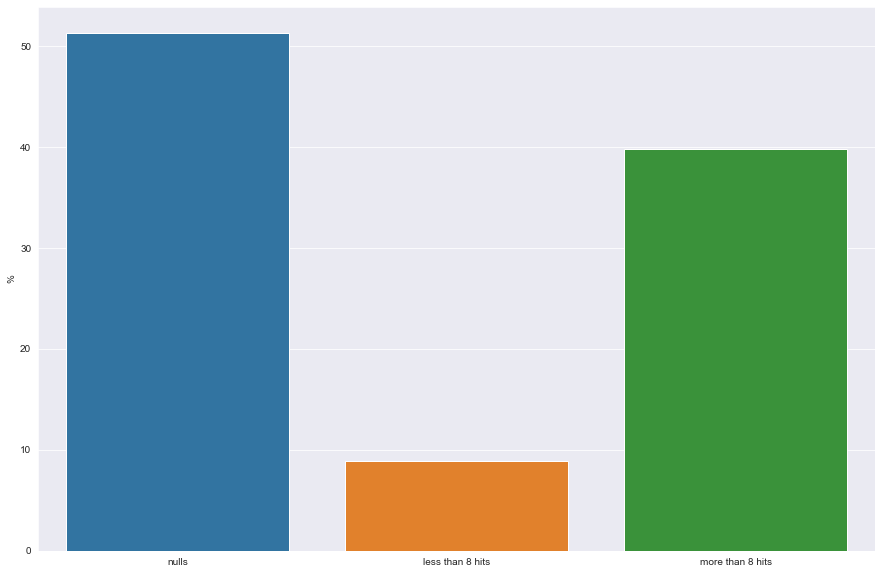

In [51]:
# display(hits_ccount)
# hits_ccount["nulls %"] = hits_ccount["nulls"] / 2671 * 100
# hits_ccount["hits %"] = hits_ccount["hits"] / 2671 * 100
plt.figure(figsize=(15, 10))
display(hits_cper)
# sns.histplot(hits_cper, stat="density")
# plt.show()
hits_cper.mean()
ax = sns.barplot(y=hits_cper.mean(), x=["nulls", "less than 8 hits", "more than 8 hits"])
ax.set_ylabel("%")
plt.show()

In [33]:
display(hits_bper)
hits_bper.mean()

,nulls,saccades,gazes
0,31.19,8.80,60.01
1,94.61,1.83,3.56
2,22.50,12.39,65.11
3,72.22,5.80,21.98
4,99.18,0.82,0.00
...,...,...,...
7908,50.32,14.23,35.45
7909,43.28,9.77,46.95
7910,89.18,6.03,4.79
7911,16.36,1.61,82.03


nulls      51.29
saccades    8.85
gazes      39.85
dtype: float64

In [7]:
# all columns except for nulls counter (0), and hitType
cols = list(df_chits.describe().columns.difference(["0"]))
hits_ccount = {"uid": [], "nulls": [], "hits": []}
hits_bcount = {"uid": [], "nulls": [], "hits": []}
pbar = tqdm(iterable=df_chits.index.values)
for row in pbar:
    curr_c = df_chits.loc[row]
    curr_b = df_bhits.loc[row]
    hits_ccount["uid"].append(curr_c.uid)
    hits_bcount["uid"].append(curr_b.uid)
    hits_ccount["nulls"].append(curr_c["0"])
    hits_bcount["nulls"].append(curr_b["0"])
    totalc = sum([int(col) * curr_c[col] for col in cols])
    totalb = sum([int(col) * curr_b[col] for col in cols])
    hits_ccount["hits"].append(totalc)
    hits_bcount["hits"].append(totalb)

hits_ccount = pd.DataFrame(hits_ccount)
hits_bcount = pd.DataFrame(hits_bcount)

  0%|          | 0/7913 [00:00<?, ?it/s]

In [8]:
# display(hits_ccount)
hits_ccount["nulls %"] = hits_ccount["nulls"] / 2671 * 100
hits_ccount["hits %"] = hits_ccount["hits"] / 2671 * 100
hits_ccount

,uid,nulls,hits,nulls %,hits %
0,ec61bab6e46741969bceb80ee2246983,833,1838,31.19,68.81
1,1fbde03890d94bddaf7aa987fc732607,2527,144,94.61,5.39
2,1ad9eea672a94518b150925bac41fcbc,601,2070,22.50,77.50
3,461b2d80132f47958e50003c16084cf4,1929,742,72.22,27.78
4,4f300efb4a9941f7a96f57e8030b12e2,2649,22,99.18,0.82
...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,1327,50.32,49.68
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,1515,43.28,56.72
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,289,89.18,10.82
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,2234,16.36,83.64


In [9]:
perc_ccount = hits_ccount[["nulls %", "hits %"]]
melted = pd.melt(perc_ccount)
melted = melted[melted["variable"] != "uid"]

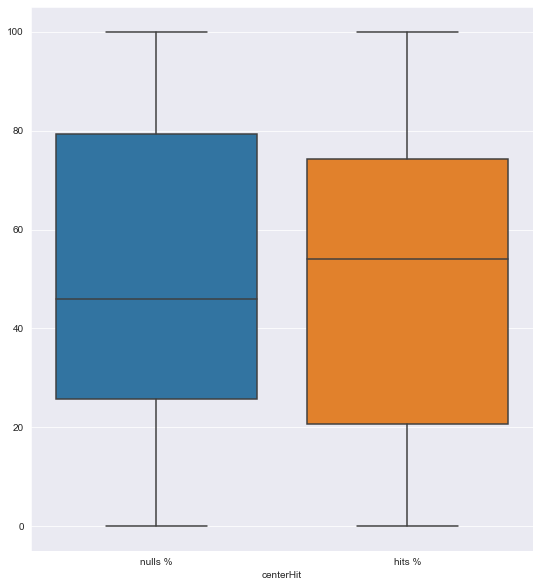

In [10]:
plt.figure(figsize=(9, 10))
ax = sns.boxplot(data=melted, x="variable", y="value")
ax.set(xlabel="centerHit", ylabel="")
plt.show()

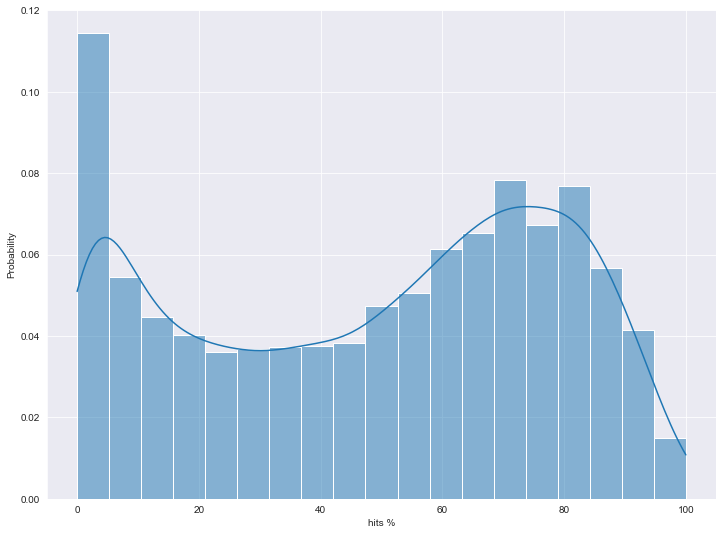

In [11]:
plt.figure(figsize=(12, 9))
sns.histplot(data=perc_ccount["hits %"], stat="probability", kde=True)
plt.show()

In [7]:
df_chits

,uid,0,1,2,3,4,5,6,7,8,...,662,663,664,665,666,667,668,669,670,671
0,ec61bab6e46741969bceb80ee2246983,833,45,15,8,9,12,2,4,2,...,0,0,0,0,0,0,0,0,0,0
1,1fbde03890d94bddaf7aa987fc732607,2527,15,7,0,2,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,1ad9eea672a94518b150925bac41fcbc,601,62,31,13,12,9,2,9,1,...,0,0,0,0,0,0,0,0,0,0
3,461b2d80132f47958e50003c16084cf4,1929,23,9,2,6,4,6,4,1,...,0,0,0,0,0,0,0,0,0,0
4,4f300efb4a9941f7a96f57e8030b12e2,2649,7,1,1,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,eda9175e9e1d4153ac2ca3038b2ab008,1344,90,25,18,17,6,10,4,4,...,0,0,0,0,0,0,0,0,0,0
7909,b8c9e625f07444cc8d4a0fc245bab5dd,1156,53,21,9,9,4,8,5,6,...,0,0,0,0,0,0,0,0,0,0
7910,2cd78ad9a37945de9f8cfd5f81c42082,2382,43,10,2,4,5,5,3,2,...,0,0,0,0,0,0,0,0,0,0
7911,dba04b626e4c4c6e89aea4fb1f9cc32b,437,1,3,2,2,3,0,1,1,...,0,0,0,0,0,0,0,0,0,0


In [8]:
# selected = df_chits[df_chits["0"] < 2671 / 2]
selected = copy.deepcopy(df_chits[[str(c) for c in range(1, 672)]])
selected

,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
0,45,15,8,9,12,2,4,2,3,3,...,0,0,0,0,0,0,0,0,0,0
1,15,7,0,2,1,0,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
2,62,31,13,12,9,2,9,1,3,4,...,0,0,0,0,0,0,0,0,0,0
3,23,9,2,6,4,6,4,1,2,4,...,0,0,0,0,0,0,0,0,0,0
4,7,1,1,0,2,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7908,90,25,18,17,6,10,4,4,2,3,...,0,0,0,0,0,0,0,0,0,0
7909,53,21,9,9,4,8,5,6,4,2,...,0,0,0,0,0,0,0,0,0,0
7910,43,10,2,4,5,5,3,2,1,2,...,0,0,0,0,0,0,0,0,0,0
7911,1,3,2,2,3,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [9]:
sum_cols = [str(i) for i in range(31, 672)]

selected[">1s"] = selected[sum_cols].sum(axis=1)

selected[">1s"]

0       16
1        0
2       15
3        5
4        0
        ..
7908    10
7909    14
7910     0
7911    17
7912    11
Name: >1s, Length: 7913, dtype: int64

In [13]:
selected.iloc[0].values

array([45, 15,  8,  9, 12,  2,  4,  2,  3,  3,  1,  2,  0,  0,  1,  1,  3,
        2,  1,  1,  1,  0,  0,  1,  2,  0,  0,  0,  0,  0,  0,  2,  0,  0,
        0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  1,  1,  1,  1,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  1,  1,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0

In [13]:
selected.sum()

1      372099
2      151068
3       90222
4       62887
5       47470
        ...  
667         0
668         0
669         0
670         0
671         1
Length: 671, dtype: int64

<AxesSubplot:ylabel='Count'>

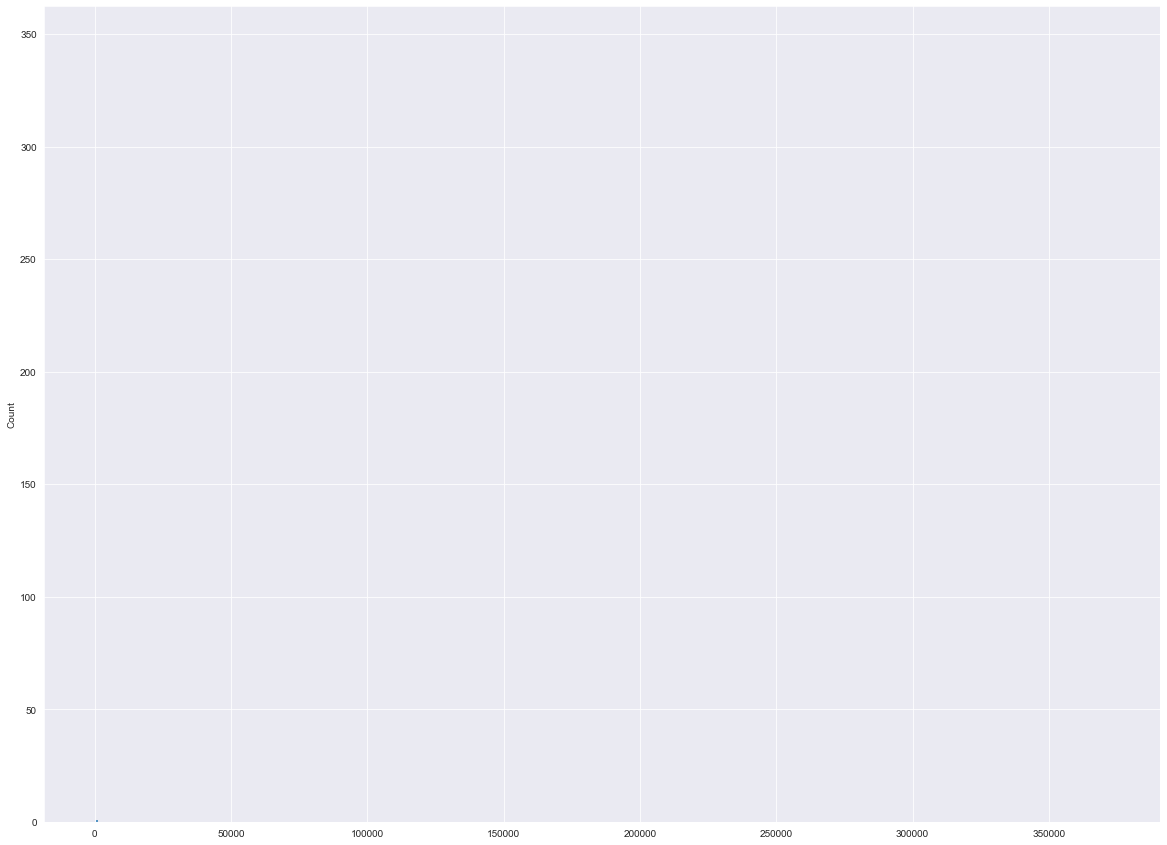

In [11]:
plt.figure(figsize=(20, 15))
# test = selected.melt()
under_cols = [str(i) for i in range(1, 31)]
test = selected[under_cols].melt()
# sns.histplot(data=test, x="variable", y="value", discrete=True)
sns.histplot(data=selected.sum())

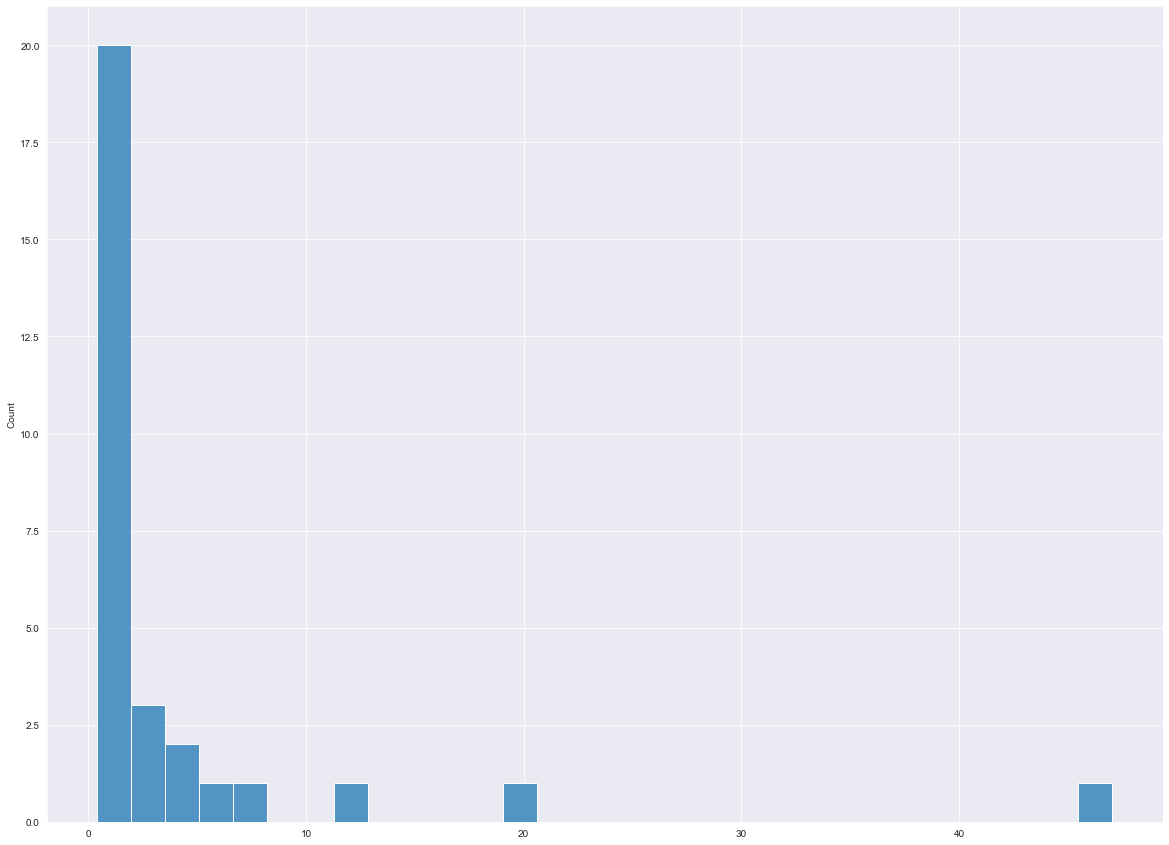

In [20]:
plt.figure(figsize=(20, 15))
x = list(selected.mean().index[:10])
y = list(selected.mean().values[:10])
sns.histplot(test[:30], bins=30)
plt.show()

In [7]:
# all columns except for nulls counter (0), and hitType
cols = list(df_chits.describe().columns.difference(["0"]))
hits_ccount = {"uid": [], "nulls": [], "hits": []}
hits_bcount = {"uid": [], "nulls": [], "hits": []}
pbar = tqdm(iterable=df_chits.index.values)
for row in pbar:
    curr_c = df_chits.loc[row]
    curr_b = df_bhits.loc[row]
    hits_ccount["uid"].append(curr_c.uid)
    hits_bcount["uid"].append(curr_b.uid)
    hits_ccount["nulls"].append(curr_c["0"])
    hits_bcount["nulls"].append(curr_b["0"])
    totalc = sum([int(col) * curr_c[col] for col in cols])
    totalb = sum([int(col) * curr_b[col] for col in cols])
    hits_ccount["hits"].append(totalc)
    hits_bcount["hits"].append(totalb)

hits_ccount = pd.DataFrame(hits_ccount)
hits_bcount = pd.DataFrame(hits_bcount)

  0%|          | 0/7913 [00:00<?, ?it/s]

In [21]:
pbar = tqdm(iterable=chits_count.index.values)
perc = {
    "c-nulls": [],
    "c-hits": [],
    "b-nulls": [],
    "b-hits": [],
}
for row in pbar:
    curr_c = hits_count.loc[row]
    nulls = curr_c.nulls
    hits = curr_c.hits
    total = nulls + hits
    nulls_per = nulls * 100 / total
    hits_per = hits * 100 / total
    if curr_c.type == "center":
        perc["c-nulls"].append(nulls_per)
        perc["c-hits"].append(hits_per)
    else:
        perc["b-nulls"].append(nulls_per)
        perc["b-hits"].append(hits_per)

print(f"Average % center nulls: {sum(perc['c-nulls'])/len(perc['c-nulls'])}")
print(f"Average % center hits: {sum(perc['c-hits'])/len(perc['c-hits'])}")
print(f"Average % box nulls: {sum(perc['b-nulls'])/len(perc['b-nulls'])}")
print(f"Average % box hits: {sum(perc['b-hits'])/len(perc['b-hits'])}")

  0%|          | 0/15826 [00:00<?, ?it/s]

Average % center nulls: 51.294452025378824
Average % center hits: 48.705547974621076
Average % box nulls: 14.41973108623297
Average % box hits: 85.58026891376635
